# <center>Diabetic Retinopathy Detection</center>

# 1.Import Libraries

In [1]:
import os
import shutil
import json
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn import (
    preprocessing,
    model_selection,
    metrics,
)

In [2]:
SEED = 42
np.random.seed = SEED
tf.random.set_seed = SEED

# 2.Data Read

In [3]:
train_dataset = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test_dataset = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
train_dataset.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

## 2.1 Label Encoder
0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

In [4]:
class_names = [
    { 'No DR' : 0 },
    { 'Mild' : 1 },
    { 'Moderate' : 2 },
    { 'Severe' : 3 },
    { 'Proliferative DR' : 4 },
]

classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']

## 2.2 Make dataframe for the file paths & the labels

In [5]:
# Training Dataframe
PATH = '/kaggle/input/aptos2019-blindness-detection/train_images/'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])
    
path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')    
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()

filepath  label
0  /kaggle/input/aptos2019-blindness-detection/tr...      2
1  /kaggle/input/aptos2019-blindness-detection/tr...      4
2  /kaggle/input/aptos2019-blindness-detection/tr...      1
3  /kaggle/input/aptos2019-blindness-detection/tr...      0
4  /kaggle/input/aptos2019-blindness-detection/tr...      0

In [6]:
# Testing Dataframe
PATH = '/kaggle/input/aptos2019-blindness-detection/test_images/'

file_paths = []
labels = []

for i in range(0,len(test_dataset)):
    file_paths.append(PATH + test_dataset.id_code[i] + '.png')
    
path_series = pd.Series(file_paths, name='filepath')
testing_data = pd.DataFrame(path_series)
testing_data.head()

filepath
0  /kaggle/input/aptos2019-blindness-detection/te...
1  /kaggle/input/aptos2019-blindness-detection/te...
2  /kaggle/input/aptos2019-blindness-detection/te...
3  /kaggle/input/aptos2019-blindness-detection/te...
4  /kaggle/input/aptos2019-blindness-detection/te...

## 2.3 Apply Gaussian Filter

#### make folder to hold the filtered train , test images

In [7]:
dest_path = '/kaggle/working/'

os.mkdir(dest_path + 'filtered_train_images')
os.mkdir(dest_path + 'filtered_test_images')

#### copy both images to new folder to filter it

In [8]:
train_source_path = '/kaggle/input/aptos2019-blindness-detection/train_images/'
train_des_path = '/kaggle/working/filtered_train_images/'

for img in tqdm.tqdm(os.listdir(train_source_path)):
    shutil.copy(train_source_path + img,train_des_path)

100%|██████████| 3662/3662 [01:41<00:00, 35.94it/s]


In [9]:
test_source_path = '/kaggle/input/aptos2019-blindness-detection/test_images/'
test_des_path = '/kaggle/working/filtered_test_images/'

for img in tqdm.tqdm(os.listdir(test_source_path)):
    shutil.copy(test_source_path + img,test_des_path)

100%|██████████| 1928/1928 [00:25<00:00, 76.19it/s]


In [10]:
def gaussian_filter(path):
    sigmaX = 15
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gaussian = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
    gaussian = cv2.resize(gaussian, (224, 224))
    cv2.imwrite(path,gaussian)

#### apply filer to the training images

In [11]:
for img in tqdm.tqdm(os.listdir(train_des_path)):
    gaussian_filter(train_des_path + img)

100%|██████████| 3662/3662 [21:29<00:00,  2.84it/s]


#### apply filter to the testing images

In [12]:
for img in tqdm.tqdm(os.listdir(test_des_path)):
    gaussian_filter(test_des_path + img)

100%|██████████| 1928/1928 [04:12<00:00,  7.64it/s]


In [13]:
# Training Dataframe
PATH = '/kaggle/working/filtered_train_images/'

file_paths = []
labels = []

for i in range(0,len(train_dataset)):
    file_paths.append(PATH + train_dataset.id_code[i] + '.png')
    labels.append(train_dataset.diagnosis[i])
    
path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')    
training_data = pd.concat([path_series, label_series], axis=1)
training_data.head()

filepath  label
0  /kaggle/working/filtered_train_images/000c1434...      2
1  /kaggle/working/filtered_train_images/001639a3...      4
2  /kaggle/working/filtered_train_images/0024cdab...      1
3  /kaggle/working/filtered_train_images/002c2135...      0
4  /kaggle/working/filtered_train_images/005b95c2...      0

In [14]:
# Testing Dataframe
PATH = '/kaggle/working/filtered_test_images/'

file_paths = []
labels = []

for i in range(0,len(test_dataset)):
    file_paths.append(PATH + test_dataset.id_code[i] + '.png')
    
path_series = pd.Series(file_paths, name='filepath')
testing_data = pd.DataFrame(path_series)
testing_data.head()

filepath
0  /kaggle/working/filtered_test_images/0005cfc8a...
1  /kaggle/working/filtered_test_images/003f0afdc...
2  /kaggle/working/filtered_test_images/006efc72b...
3  /kaggle/working/filtered_test_images/00836aaac...
4  /kaggle/working/filtered_test_images/009245722...

#### plot 25 sample from training images

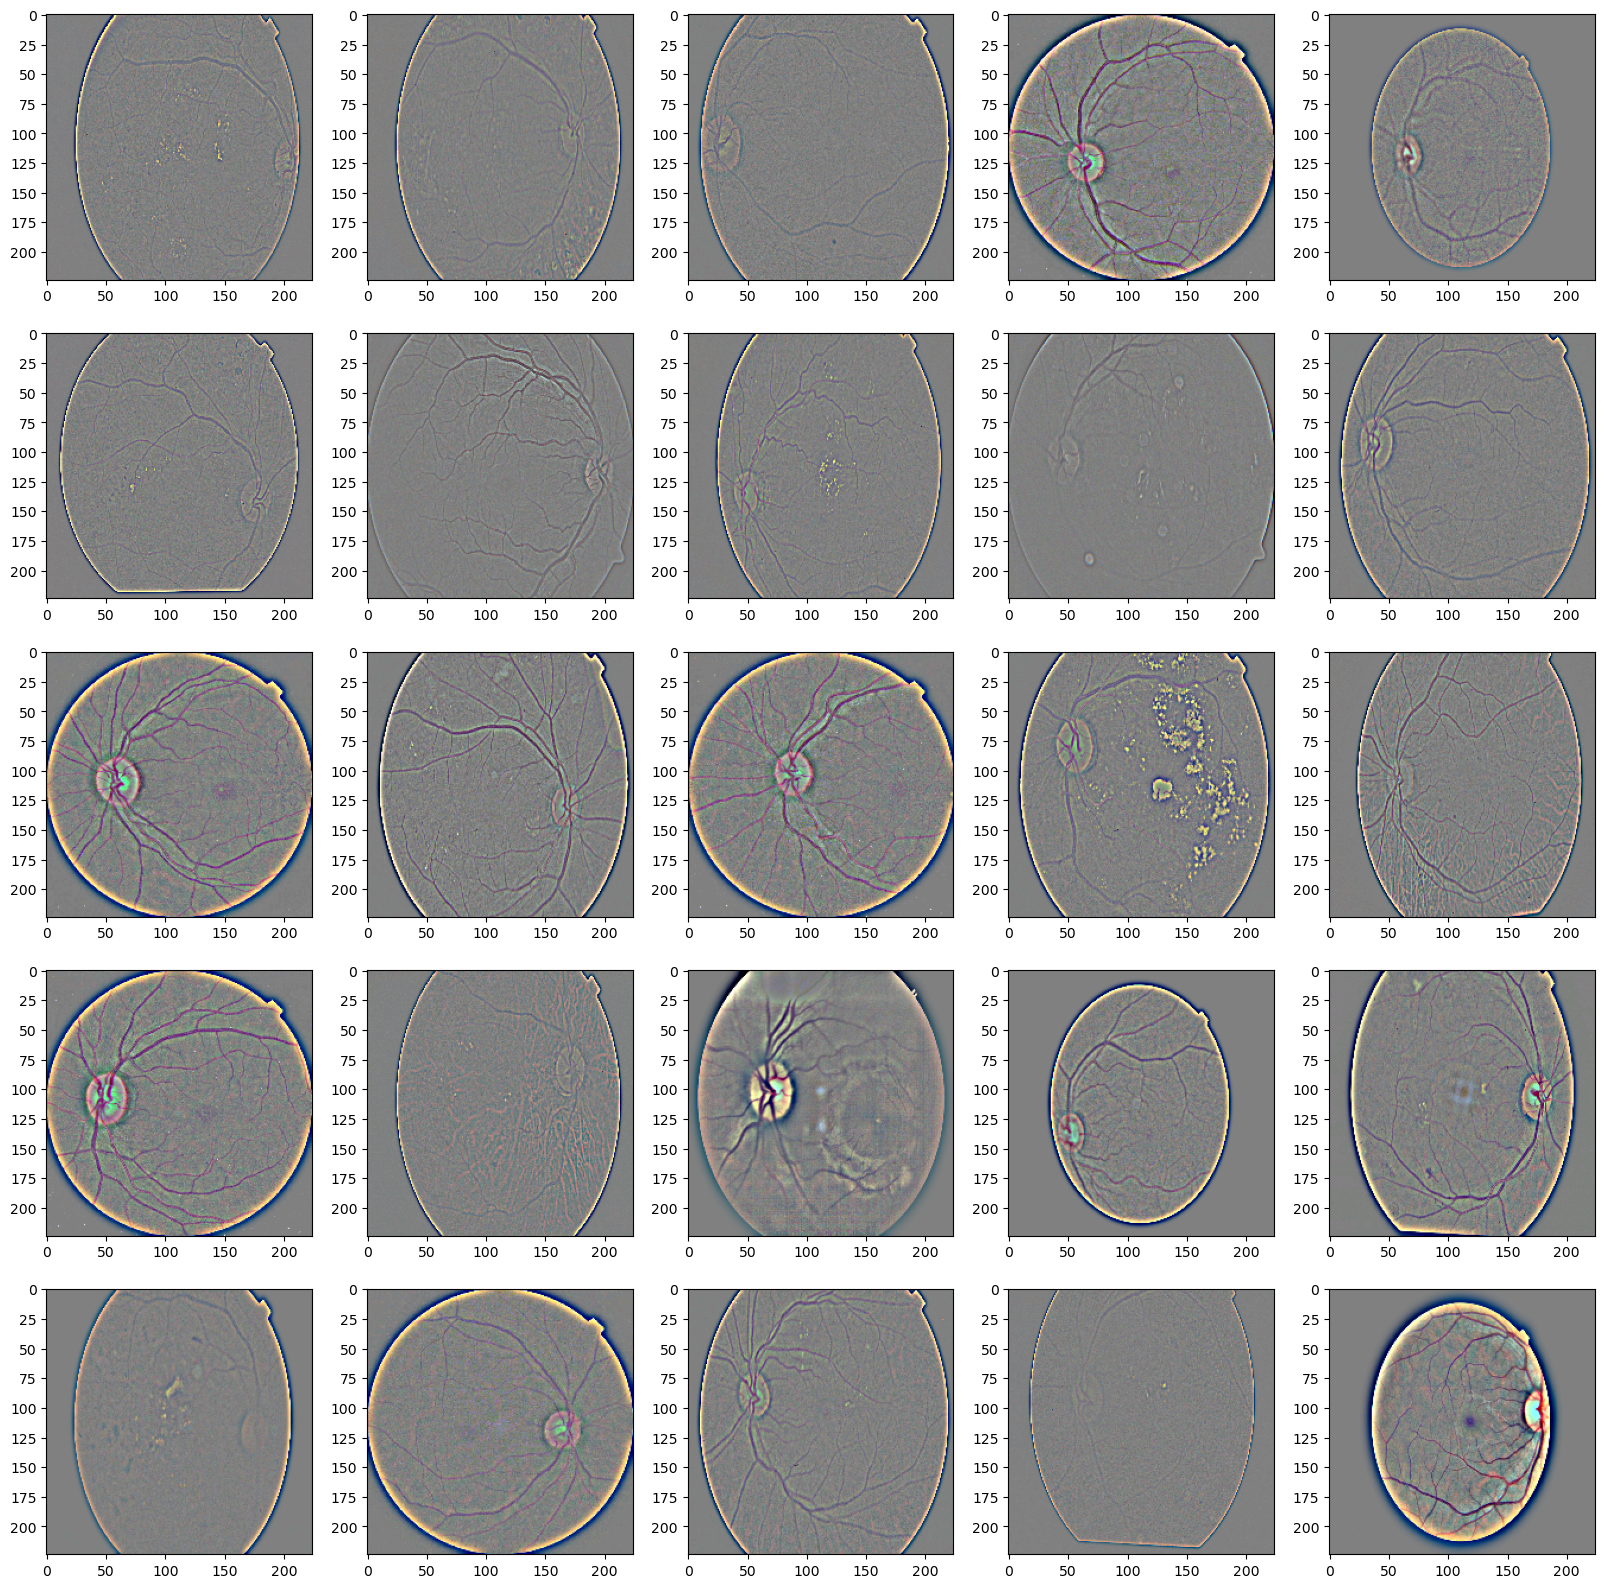

In [15]:
plt.figure(figsize=(20, 20))
for idx in range(0,25):
    image = cv2.imread(training_data.filepath[idx])
    plt.subplot(5,5,idx+1)
    plt.imshow(image)
plt.show()

## 2.3 Data Spliting

In [16]:
x = training_data.filepath
y = training_data.label

----------------------------------------------

# 2. Modeling

## 2.1 CNN training with corss validation

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (5,5), padding="same", input_shape=(224,224,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(128, (5,5), padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
 
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(256, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128,activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(len(classes), activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     409728    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       409728    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

#### Cross Validation 

In [18]:
path = '/kaggle/input/aptos2019-blindness-detection/train.csv'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)


kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

# Variable for keeping count of split we are executing
j = 0

model_history = []

# K-fold Train and test for each split
for train_idx, val_idx in tqdm.tqdm(list(kfold.split(x,y))):
    x_train_df = training_data.iloc[train_idx]
    x_valid_df = training_data.iloc[val_idx]
    
    j+=1

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)
    
    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=path,
                                                 x_col="filepath", y_col="label",
                                                 class_mode="raw",
                                                 target_size=(224,224), batch_size=32)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode='max', restore_best_weights=True)

    history = model.fit(training_set,validation_data=validation_set,epochs = 10,callbacks=[early_stopping])
    
    model_history.append(history)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Found 3295 validated image filenames.
Found 367 validated image filenames.
Epoch 1/10
103/103 [==============================] - 54s 422ms/step - loss: 1.1484 - accuracy: 0.5612 - val_loss: 0.9314 - val_accuracy: 0.6676
Epoch 2/10
103/103 [==============================] - 43s 412ms/step - loss: 0.9672 - accuracy: 0.6719 - val_loss: 0.9156 - val_accuracy: 0.6866
Epoch 3/10
103/103 [==============================] - 43s 414ms/step - loss: 0.9400 - accuracy: 0.6783 - val_loss: 0.8691 - val_accuracy: 0.6894
Epoch 4/10
103/103 [==============================] - 42s 408ms/step - loss: 0.8831 - accuracy: 0.6904 - val_loss: 0.7957 - val_accuracy: 0.7084
Epoch 5/10
103/103 [==============================] - 42s 406ms/step - loss: 0.8648 - accuracy: 0.6935 - val_loss: 0.8421 - val_accuracy: 0.7057
Epoch 6/10
103/103 [==============================] - 43s 412ms/step - loss: 0.8476 - accuracy: 0.6968 - val_loss: 0.8112 - val_accuracy: 0.7112
Epoch 7/10
103/103 [==============================] - 4

 10%|█         | 1/10 [07:15<1:05:18, 435.41s/it]

Found 3295 validated image filenames.
Found 367 validated image filenames.
Epoch 1/10
103/103 [==============================] - 42s 409ms/step - loss: 0.7716 - accuracy: 0.7205 - val_loss: 0.7701 - val_accuracy: 0.7384
Epoch 2/10
103/103 [==============================] - 42s 407ms/step - loss: 0.7620 - accuracy: 0.7250 - val_loss: 0.7838 - val_accuracy: 0.7221
Epoch 3/10
103/103 [==============================] - 42s 406ms/step - loss: 0.7585 - accuracy: 0.7247 - val_loss: 0.7576 - val_accuracy: 0.7193
Epoch 4/10
103/103 [==============================] - 42s 405ms/step - loss: 0.7536 - accuracy: 0.7284 - val_loss: 0.7592 - val_accuracy: 0.7221
Epoch 5/10
103/103 [==============================] - 42s 407ms/step - loss: 0.7371 - accuracy: 0.7329 - val_loss: 0.7589 - val_accuracy: 0.7139
Epoch 6/10
103/103 [==============================] - 42s 407ms/step - loss: 0.7341 - accuracy: 0.7366 - val_loss: 0.7550 - val_accuracy: 0.7357


 20%|██        | 2/10 [11:27<43:41, 327.71s/it]  

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 418ms/step - loss: 0.7810 - accuracy: 0.7200 - val_loss: 0.7290 - val_accuracy: 0.7186
Epoch 2/10
103/103 [==============================] - 43s 420ms/step - loss: 0.7604 - accuracy: 0.7200 - val_loss: 0.6875 - val_accuracy: 0.7322
Epoch 3/10
103/103 [==============================] - 42s 409ms/step - loss: 0.7536 - accuracy: 0.7236 - val_loss: 0.7159 - val_accuracy: 0.7350
Epoch 4/10
103/103 [==============================] - 42s 406ms/step - loss: 0.7388 - accuracy: 0.7342 - val_loss: 0.6972 - val_accuracy: 0.7295
Epoch 5/10
103/103 [==============================] - 43s 414ms/step - loss: 0.7386 - accuracy: 0.7318 - val_loss: 0.6880 - val_accuracy: 0.7322
Epoch 6/10
103/103 [==============================] - 42s 403ms/step - loss: 0.7100 - accuracy: 0.7363 - val_loss: 0.7005 - val_accuracy: 0.7350
Epoch 7/10
103/103 [==============================] - 4

 30%|███       | 3/10 [18:31<43:22, 371.75s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 413ms/step - loss: 0.6904 - accuracy: 0.7421 - val_loss: 0.5491 - val_accuracy: 0.7923
Epoch 2/10
103/103 [==============================] - 42s 407ms/step - loss: 0.6774 - accuracy: 0.7497 - val_loss: 0.5577 - val_accuracy: 0.7842
Epoch 3/10
103/103 [==============================] - 42s 409ms/step - loss: 0.6676 - accuracy: 0.7546 - val_loss: 0.5510 - val_accuracy: 0.7978
Epoch 4/10
103/103 [==============================] - 42s 409ms/step - loss: 0.6687 - accuracy: 0.7482 - val_loss: 0.5758 - val_accuracy: 0.7787
Epoch 5/10
103/103 [==============================] - 42s 408ms/step - loss: 0.6498 - accuracy: 0.7570 - val_loss: 0.5924 - val_accuracy: 0.7896
Epoch 6/10
103/103 [==============================] - 42s 412ms/step - loss: 0.6332 - accuracy: 0.7670 - val_loss: 0.6330 - val_accuracy: 0.7760
Epoch 7/10
103/103 [==============================] - 4

 40%|████      | 4/10 [24:50<37:27, 374.59s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 413ms/step - loss: 0.6680 - accuracy: 0.7506 - val_loss: 0.5717 - val_accuracy: 0.7842
Epoch 2/10
103/103 [==============================] - 43s 417ms/step - loss: 0.6605 - accuracy: 0.7582 - val_loss: 0.6047 - val_accuracy: 0.7623
Epoch 3/10
103/103 [==============================] - 42s 410ms/step - loss: 0.6513 - accuracy: 0.7576 - val_loss: 0.5603 - val_accuracy: 0.8005
Epoch 4/10
103/103 [==============================] - 42s 408ms/step - loss: 0.6255 - accuracy: 0.7658 - val_loss: 0.5734 - val_accuracy: 0.7650
Epoch 5/10
103/103 [==============================] - 43s 416ms/step - loss: 0.6245 - accuracy: 0.7694 - val_loss: 0.5858 - val_accuracy: 0.7787
Epoch 6/10
103/103 [==============================] - 42s 409ms/step - loss: 0.6142 - accuracy: 0.7749 - val_loss: 0.5758 - val_accuracy: 0.7623
Epoch 7/10
103/103 [==============================] - 4

 50%|█████     | 5/10 [30:31<30:11, 362.36s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 413ms/step - loss: 0.6322 - accuracy: 0.7670 - val_loss: 0.5806 - val_accuracy: 0.7760
Epoch 2/10
103/103 [==============================] - 42s 410ms/step - loss: 0.6169 - accuracy: 0.7734 - val_loss: 0.5750 - val_accuracy: 0.7814
Epoch 3/10
103/103 [==============================] - 43s 412ms/step - loss: 0.6184 - accuracy: 0.7673 - val_loss: 0.6052 - val_accuracy: 0.7678
Epoch 4/10
103/103 [==============================] - 42s 410ms/step - loss: 0.6043 - accuracy: 0.7755 - val_loss: 0.6290 - val_accuracy: 0.7514
Epoch 5/10
103/103 [==============================] - 44s 425ms/step - loss: 0.5869 - accuracy: 0.7791 - val_loss: 0.5949 - val_accuracy: 0.7732
Epoch 6/10
103/103 [==============================] - 43s 414ms/step - loss: 0.5977 - accuracy: 0.7740 - val_loss: 0.5936 - val_accuracy: 0.7623
Epoch 7/10
103/103 [==============================] - 4

 60%|██████    | 6/10 [36:09<23:36, 354.08s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 416ms/step - loss: 0.6204 - accuracy: 0.7706 - val_loss: 0.5651 - val_accuracy: 0.7923
Epoch 2/10
103/103 [==============================] - 42s 408ms/step - loss: 0.6048 - accuracy: 0.7709 - val_loss: 0.5923 - val_accuracy: 0.7923
Epoch 3/10
103/103 [==============================] - 42s 407ms/step - loss: 0.5930 - accuracy: 0.7737 - val_loss: 0.5719 - val_accuracy: 0.7760
Epoch 4/10
103/103 [==============================] - 43s 417ms/step - loss: 0.5876 - accuracy: 0.7700 - val_loss: 0.5974 - val_accuracy: 0.7596
Epoch 5/10
103/103 [==============================] - 42s 409ms/step - loss: 0.5773 - accuracy: 0.7809 - val_loss: 0.5840 - val_accuracy: 0.7896
Epoch 6/10
103/103 [==============================] - 43s 415ms/step - loss: 0.5806 - accuracy: 0.7843 - val_loss: 0.5723 - val_accuracy: 0.8060
Epoch 7/10
103/103 [==============================] - 4

 70%|███████   | 7/10 [43:53<19:30, 390.01s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 412ms/step - loss: 0.5372 - accuracy: 0.7967 - val_loss: 0.4604 - val_accuracy: 0.8142
Epoch 2/10
103/103 [==============================] - 43s 413ms/step - loss: 0.5259 - accuracy: 0.7985 - val_loss: 0.4644 - val_accuracy: 0.8306
Epoch 3/10
103/103 [==============================] - 43s 417ms/step - loss: 0.5203 - accuracy: 0.7998 - val_loss: 0.4740 - val_accuracy: 0.8279
Epoch 4/10
103/103 [==============================] - 42s 408ms/step - loss: 0.5064 - accuracy: 0.8101 - val_loss: 0.4944 - val_accuracy: 0.8197
Epoch 5/10
103/103 [==============================] - 42s 407ms/step - loss: 0.5215 - accuracy: 0.8013 - val_loss: 0.4553 - val_accuracy: 0.8470
Epoch 6/10
103/103 [==============================] - 42s 412ms/step - loss: 0.4979 - accuracy: 0.8116 - val_loss: 0.4712 - val_accuracy: 0.8197
Epoch 7/10
103/103 [==============================] - 4

 80%|████████  | 8/10 [50:57<13:21, 400.93s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 414ms/step - loss: 0.4880 - accuracy: 0.8110 - val_loss: 0.4751 - val_accuracy: 0.8169
Epoch 2/10
103/103 [==============================] - 43s 413ms/step - loss: 0.4847 - accuracy: 0.8155 - val_loss: 0.4229 - val_accuracy: 0.8388
Epoch 3/10
103/103 [==============================] - 42s 406ms/step - loss: 0.4735 - accuracy: 0.8192 - val_loss: 0.4399 - val_accuracy: 0.8306
Epoch 4/10
103/103 [==============================] - 42s 408ms/step - loss: 0.4774 - accuracy: 0.8198 - val_loss: 0.4719 - val_accuracy: 0.8279
Epoch 5/10
103/103 [==============================] - 42s 410ms/step - loss: 0.4581 - accuracy: 0.8292 - val_loss: 0.4412 - val_accuracy: 0.8306
Epoch 6/10
103/103 [==============================] - 42s 411ms/step - loss: 0.4425 - accuracy: 0.8262 - val_loss: 0.5093 - val_accuracy: 0.8060
Epoch 7/10
103/103 [==============================] - 4

 90%|█████████ | 9/10 [55:54<06:08, 368.42s/it]

Found 3296 validated image filenames.
Found 366 validated image filenames.
Epoch 1/10
103/103 [==============================] - 43s 415ms/step - loss: 0.4831 - accuracy: 0.8174 - val_loss: 0.4426 - val_accuracy: 0.8497
Epoch 2/10
103/103 [==============================] - 42s 408ms/step - loss: 0.4757 - accuracy: 0.8240 - val_loss: 0.4219 - val_accuracy: 0.8579
Epoch 3/10
103/103 [==============================] - 42s 412ms/step - loss: 0.4658 - accuracy: 0.8177 - val_loss: 0.4130 - val_accuracy: 0.8525
Epoch 4/10
103/103 [==============================] - 42s 406ms/step - loss: 0.4662 - accuracy: 0.8201 - val_loss: 0.3925 - val_accuracy: 0.8552
Epoch 5/10
103/103 [==============================] - 42s 407ms/step - loss: 0.4477 - accuracy: 0.8310 - val_loss: 0.4179 - val_accuracy: 0.8415
Epoch 6/10
103/103 [==============================] - 44s 430ms/step - loss: 0.4337 - accuracy: 0.8389 - val_loss: 0.4308 - val_accuracy: 0.8443
Epoch 7/10
103/103 [==============================] - 4

100%|██████████| 10/10 [1:03:41<00:00, 382.11s/it]


In [19]:
acc,val_acc,loss,val_loss = [],[],[],[]
for idx in range(0,len(model_history)):    
    acc.extend(model_history[idx].history['accuracy'])
    val_acc.extend(model_history[idx].history['val_accuracy'])
    
    loss.extend(model_history[idx].history['loss'])
    val_loss.extend(model_history[idx].history['val_loss'])

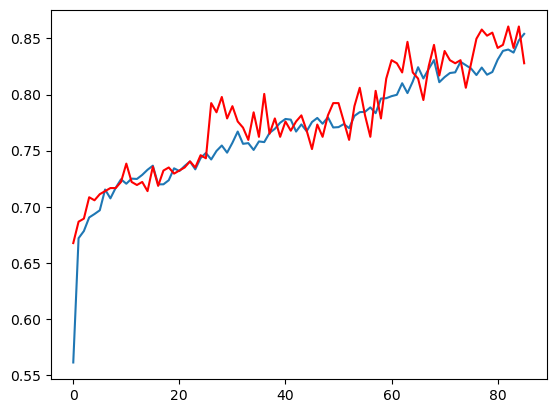

In [20]:
plt.plot(acc)
plt.plot(val_acc,color = 'red')
plt.show()

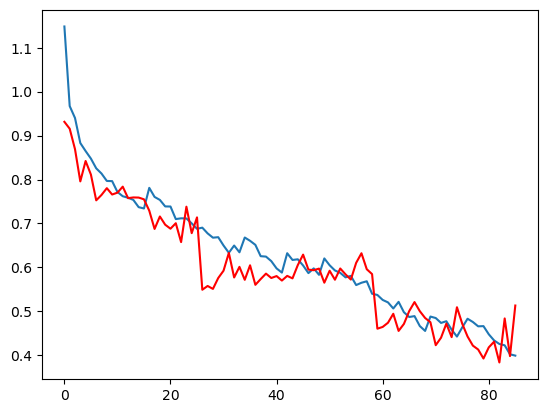

In [21]:
plt.plot(loss)
plt.plot(val_loss,color = 'red')
plt.show()

#### save model

In [22]:
model.save("/kaggle/working/diabetic_retina_model.h5")

#### save model history

In [23]:
model_infos = { 
  "loss": loss, 
  "accuracy": acc, 
  "val_loss": val_loss,
  "val_acc" : val_acc
} 
    
with open("/kaggle/working/model_history.json", "w") as outfile:
    json.dump(model_infos, outfile)

In [24]:
file = open('/kaggle/working/model_history.json')
  
data = json.load(file)

-------------------------------------------------------------------------

#### testing model

In [25]:
test_path = '/kaggle/input/aptos2019-blindness-detection/test.csv'

testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

testing_set = train_datagen.flow_from_dataframe(dataframe=testing_data, directory=test_path,
                                                 x_col="filepath",y_col=None,class_mode=None,
                                                 target_size=(224,224), batch_size=32)

Found 1928 validated image filenames.


In [26]:
preds = model.predict(testing_set)
pred = np.argmax(preds, axis=1)
pred

61/61 [==============================] - 23s 383ms/step


array([2, 2, 2, ..., 3, 2, 2])

In [27]:
test_dataset['diagnosis'] = pred

In [28]:
test_dataset.to_csv('/kaggle/working/submission.csv')